In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import requests
import json
import numpy as np
from collections import Counter

In [61]:
headers = {
    'Ocp-Apim-Subscription-Key': 'a9a9efa851b44d5bbd6c841215a99e00',
    'Content-Type': 'application/x-www-form-urlencoded'
}

results = []

count = 500
offset = 0
while count > 0:
    query ="expr=Composite(AA.AuN=='john smith')&count="+str(count)+"&offset="+str(offset)+"+&attributes=D,AA.AuN,AA.AuId,F.FId,J.JId,AA.AfId"
    offset += count
    r = requests.post('https://westus.api.cognitive.microsoft.com/academic/v1.0/evaluate', 
                      data=query, headers=headers)
    js = r.json()
    count = len(js["entities"])
    results += js["entities"]

500
500
93
0


In [62]:
ids=[]
for _row in results:
    for _author in _row["AA"]:
        ids.append(_author["AuId"])

In [66]:
class Author:
    def __init__(self,author_id):
        self.author_id = author_id
        self.coauthors = []
        self.fields = []
        self.journals = []
        self.affiliations = []
        self.dates = []
        
    def append(self,coauthors,fields,journal,affiliation,date):
        coauthors.remove(self.author_id)
        self.coauthors.append(coauthors)
        self.fields.append(fields)
        self.journals.append(journal)
        self.affiliations.append(affiliation)
        self.dates.append(date)
        
authors = {}
for _row in results:
    _coauthors = [_a["AuId"] for _a in _row["AA"]]
    
    _fields = None
    if "F" in _row:
        _fields = [_f["FId"] for _f in _row["F"]]
    
    _journal = None
    if "J" in _row:
        _journal = _row["J"]["JId"]
    
    _date = None
    if "D" in _row:
        _date = _row["D"]
    
    for _a in _row["AA"]:
        _author_id = _a["AuId"]
        _affiliation = None
        if "AfId" in _a:
            _affiliation = _a["AfId"]
        if _author_id not in authors:
            authors[_author_id] = Author(_author_id)
        
        authors[_author_id].append(_coauthors,_fields,_journal,_affiliation,_date)

Counter({2: 811, 1: 605, 3: 149, 0: 140, 4: 80, 5: 25, 8: 12, 7: 10, 9: 9, 11: 7, 18: 7, 6: 5, 10: 3, 13: 3, 16: 2, 83: 2, 21: 2, 26: 2, 15: 2, 33: 2, 19: 2, 25: 2, 12: 1, 14: 1, 77: 1, 17: 1, 23: 1, 89: 1, 29: 1, 30: 1, 38: 1, 40: 1, 42: 1, 76: 1, 138: 1})


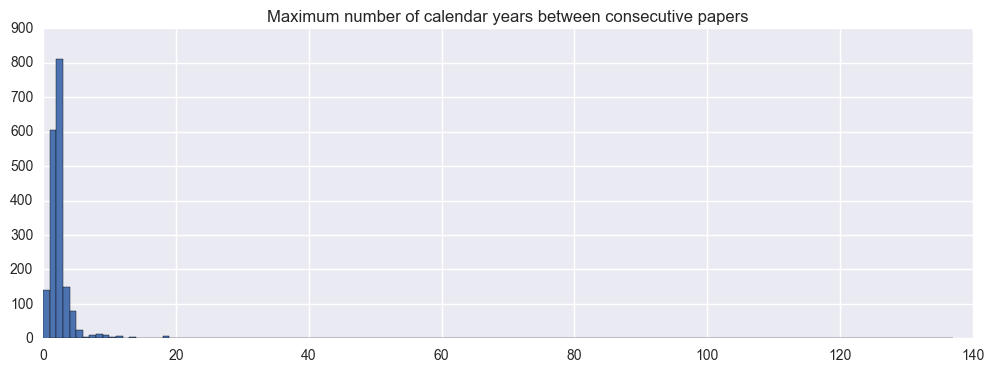

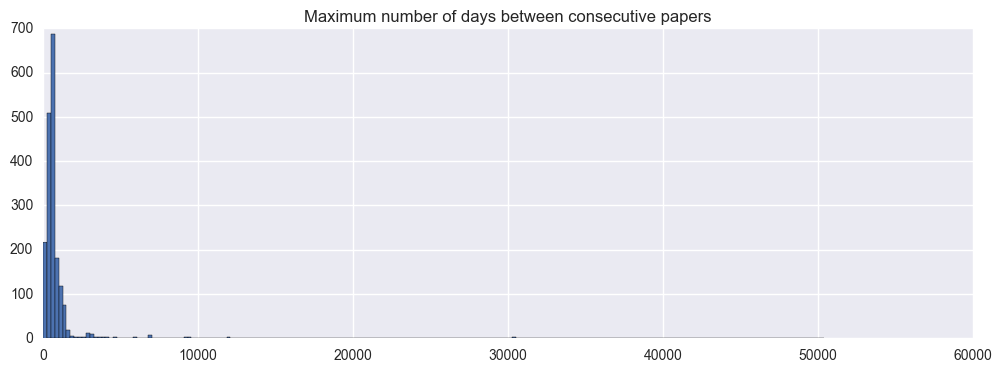

In [87]:
# Plot the greatest separation in consecutive publication dates
max_days = []
max_years = []
parse = lambda d:int(d.split("-")[0])
for _,_a in authors.items():
    _dates = sorted(list(map(dateutil.parser.parse,_a.dates)))
    if len(_dates) == 1:
        continue
    else:
        max_years.append(max(np.diff([d.year for d in _dates])))
        max_days.append(max(np.diff(_dates)).days)

#medians = [max(_yrs) for _yrs in years if len(_yrs) > 1]
#iqr = [max(_yrs) - min(_yrs) for _yrs in years if len(_yrs) > 1]
#plt.hist(medians,iqr)
c = Counter(max_years)
fig,ax = plt.subplots(figsize=(12,4))
ax.hist(max_years,bins=range(0,max(max_years)))
ax.set_title("Maximum number of calendar years between consecutive papers")
print(c)

fig,ax = plt.subplots(figsize=(12,4))
ax.hist(max_days,bins=200)
ax.set_title("Maximum number of days between consecutive papers")